In [1]:
import pickle
import pandas as pd
import pre_processing_tr as pr
import matplotlib.pyplot as plt
from matplotlib import dates
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
tweets = pd.read_excel('derlemler/nedenttoldu_user_tweets.xlsx')
tweets.tail()

,Tweet Id,Text,Name,Screen Name,UTC,Created At,Favorites,Retweets,Language,Client,Tweet Type,URLs,Hashtags,Mentions,Media Type,Media URLs,Unnamed: 16,Unnamed: 17,Unnamed: 18
3195,1202103047519948805,#çarşamba https://t.co/xNVJQBgnfn,Neden TT oldu?,nedenttoldu,2019-12-04T05:51:15.000Z,Wed Dec 04 05:51:15 +0000 2019,721,50,und,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Tweet,NaN,1,0,video,https://video.twimg.com/ext_tw_video/120210297...,NaN,NaN,NaN
3196,1202101115552256000,Vakıflar Bankası'nın yüzde 58.5 oranındaki his...,Neden TT oldu?,nedenttoldu,2019-12-04T05:43:34.000Z,Wed Dec 04 05:43:34 +0000 2019,55,21,tr,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Tweet,https://t24.com.tr/amp/haber/vakiflar-bankasi-...,0,0,NaN,NaN,NaN,NaN,NaN
3197,1201984589834706945,Ben Bilirim yarışmasında sorulan Hasan Ali Yüc...,Neden TT oldu?,nedenttoldu,2019-12-03T22:00:32.000Z,Tue Dec 03 22:00:32 +0000 2019,273,39,tr,"<a href=""https://studio.twitter.com"" rel=""nofo...",Tweet,NaN,0,0,video,https://video.twimg.com/amplify_video/12019839...,NaN,NaN,NaN
3198,1201973844774440960,Ordu'da evinin önünde bıçaklanan 20 yaşındaki ...,Neden TT oldu?,nedenttoldu,2019-12-03T21:17:50.000Z,Tue Dec 03 21:17:50 +0000 2019,473,130,tr,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Tweet,https://www.sozcu.com.tr/2019/gundem/genc-bale...,1,0,NaN,NaN,NaN,NaN,NaN
3199,1201960079949488130,Fenerbahçe - İstanbulspor maçının özeti... htt...,Neden TT oldu?,nedenttoldu,2019-12-03T20:23:09.000Z,Tue Dec 03 20:23:09 +0000 2019,34,1,tr,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Reply,https://youtu.be/BGaYAk825Ls,0,0,NaN,NaN,NaN,NaN,NaN


In [3]:
print(f"Toplam örnek sayısı: {len(tweets)}")

Toplam örnek sayısı: 3200


In [4]:
#Tweet zamanı ve yazıların düzenlenmesi
tweets.Text = tweets.Text.apply(pr.pre_process)
tweets.UTC = tweets.UTC.apply(lambda x: x[:10])

In [5]:
#Önceden eğitilmiş modelin yüklenmesi
filename = 'modeller/5-kategori_vocab.sav'
loaded_vocab = pickle.load(open(filename, 'rb'))

cv = CountVectorizer(vocabulary=loaded_vocab)
text_vector = cv.fit_transform(tweets.Text)

In [6]:
filename = 'modeller/5-kategori.sav'
loaded_model = pickle.load(open(filename, 'rb'))

class_mapping = {0: 'Diğer', 1: 'Ekonomi', 2: 'Siyaset', 3: 'Spor', 4: 'Teknoloji_Bilim'}

In [7]:
#Tahmin aşaması
preds = loaded_model.predict(text_vector)
preds_mapped = []
for pred in preds:
    preds_mapped.append(class_mapping[pred])

In [8]:
print("Bütün tweetlerin sınıflandırılması sonrası tahmin edilen kategorilere göre toplam haber sayısı.")
for cat in set(preds_mapped):
    print(f"{cat}: {preds_mapped.count(cat)}")

Bütün tweetlerin sınıflandırılması sonrası tahmin edilen kategorilere göre toplam haber sayısı.
Diğer: 1079
Ekonomi: 490
Spor: 370
Siyaset: 693
Teknoloji_Bilim: 568


In [9]:
# figür için yardımcı metot
def window_average(x,N):
    low_index = 0
    high_index = low_index + N
    w_avg = []
    while(high_index<len(x)):
        temp = sum(x[low_index:high_index])/N
        w_avg.append(temp)
        low_index = low_index + N
        high_index = high_index + N
    return w_avg

In [10]:
#tarihe göre haber sayısı hesaplamaları
data = pd.concat([tweets.UTC, pd.DataFrame(preds_mapped)], axis=1) 
data['day'] = data['UTC'].apply(lambda x: x.split()[0])
counts = data.groupby(['day', 0]).agg(len)
counts = counts.unstack().fillna(0)
date = pd.to_datetime(tweets.UTC).unique()

In [11]:
#bir haftalık kayan pencerede çıkan toplam haber sayısı
dgr = counts.UTC.iloc[:, 0].rolling(7).sum().values
eko = counts.UTC.iloc[:, 1].rolling(7).sum().values
spr = counts.UTC.iloc[:, 2].rolling(7).sum().values
sys = counts.UTC.iloc[:, 3].rolling(7).sum().values
tec = counts.UTC.iloc[:, 4].rolling(7).sum().values

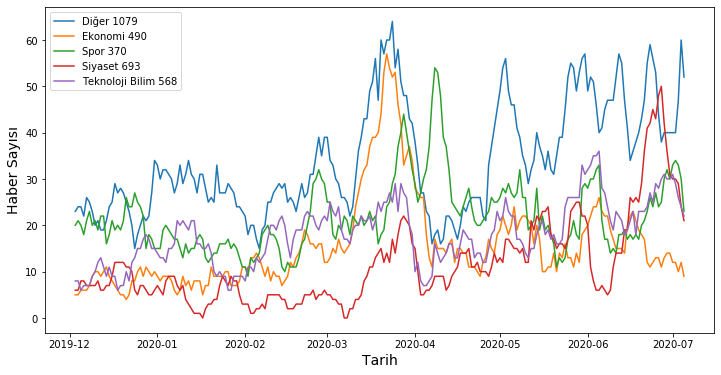

In [12]:
# Figür oluşturulması
f = plt.figure()
f.set_size_inches(12, 6)
plt.plot(date, dgr, label = f"Diğer {preds_mapped.count('Diğer')}")
plt.plot(date, eko, label = f"Ekonomi {preds_mapped.count('Ekonomi')}")
plt.plot(date, spr, label = f"Spor {preds_mapped.count('Spor')}")
plt.plot(date, sys, label = f"Siyaset {preds_mapped.count('Siyaset')}")
plt.plot(date, tec, label = f"Teknoloji Bilim {preds_mapped.count('Teknoloji_Bilim')}")
plt.xlabel('Tarih', fontsize=14)
plt.ylabel('Haber Sayısı', fontsize=14)
plt.legend(loc='upper left')